In [17]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    """Checks if the code is running in Google Colab

    Returns:
        bool: _description_
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_google_colab():
    print("Running in Google Colab")
    # Install necessary packages in Google Colab
    !rm -r sample_data/
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !cp -r anesthesia_anomaly_detection/* .
    !rm -r anesthesia_anomaly_detection/
    !pip install vitaldb
    create_dataset = False
else:
    print("Running locally")

### Datasetpath
directory = 'data/'
datasetpath = 'dataset03/'
vitaldbpath = 'vitaldb_sevofl/'

### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt
import pickle

### Custom functions
import modules as md

Running locally


In [18]:
bis.index.shape

(262,)

In [19]:
### Load the datasets
bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info_non_norm = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info_non_norm.load('01_info_norm_none.npz')

info_non_norm = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info_non_norm.load('01_info_norm_none.npz')

bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

mac = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
mac.load('03_mac.npz')

train_index, val_index, test_index = bis.split(np.array(bis.index))

# Seperate the Data in + 60 years and older patients

In [20]:
young_index_train = np.where(info_non_norm.train_dataset[:,1] <  60)
old_index_train   = np.where(info_non_norm.train_dataset[:,1] >= 60)

print(young_index_train[0].shape, old_index_train[0].shape)

young_index_val = np.where(info_non_norm.validation_dataset[:,1] <  60)
old_index_val   = np.where(info_non_norm.validation_dataset[:,1] >= 60)

print(young_index_val[0].shape, old_index_val[0].shape)

young_index_test = np.where(info_non_norm.test_dataset[:,1] <  60)
old_index_test   = np.where(info_non_norm.test_dataset[:,1] >= 60)

print(young_index_test[0].shape, old_index_test[0].shape)

(76,) (112,)
(18,) (16,)
(14,) (26,)


# Seperate the Data in Male and Female patients

In [21]:
m_index_train = np.where(info_non_norm.train_dataset[:,0] == 0.5)
f_index_train = np.where(info_non_norm.train_dataset[:,0] == -0.5)

print(m_index_train[0].shape, f_index_train[0].shape)

m_index_val = np.where(info_non_norm.validation_dataset[:,0] == 0.5)
f_index_val = np.where(info_non_norm.validation_dataset[:,0] == -0.5)

print(m_index_val[0].shape, f_index_val[0].shape)

m_index_test = np.where(info_non_norm.test_dataset[:,0] == 0.5)
f_index_test = np.where(info_non_norm.test_dataset[:,0] == -0.5)

print(m_index_test[0].shape, f_index_test[0].shape)

(123,) (65,)
(18,) (16,)
(26,) (14,)


# Load prediction data

In [22]:
# Load test prediction data
with open('models/VPropNN_Balanced/full/prediction.pkl', 'rb') as f:
    y_pred = pickle.load(f)

from utils.evaluation import phases_report, phases_report_std

# MDPE

In [24]:
timefilter = (bis.test_dataset == 0.0)

groundtruth = np.copy(bis.test_dataset)
groundtruth[timefilter] = np.nan
groundtruth = groundtruth

y_pred[timefilter] = np.nan
y_pred_all = y_pred


mdpe_all = np.nanmedian((groundtruth - y_pred_all) / groundtruth * 100)
mdpe_m = np.nanmedian((groundtruth[m_index_test] - y_pred[m_index_test]) / groundtruth[m_index_test] * 100)
mdpe_f = np.nanmedian((groundtruth[f_index_test] - y_pred[f_index_test]) / groundtruth[f_index_test] * 100)

print(mdpe_all, mdpe_m, mdpe_f)

5.0321426 5.0232077 5.0622187


In [6]:
def get_anaesthesia_phases_balanced(bis_dataset: np.array ,mac_dataset: np.array, N: int = 60) -> dict:
    """
    A function to detect the anesthesia phases based on a balanced anaesthesia in a given dataset. The function calculates the
    moving average of the propofol rate and detects the start and end of the anesthesia phases
    by detecting the first and last occurence of a propofol rate below 40 ml/h and above 5 ml/h.

    Args:
        dataset (np.array): Propofol rate dataset
        N (int): Number of samples to average

    Returns:
        dict: Dict where each key contains a List of the end index of induction and start index of the recovery phases
    """
    anesthesia_phases = []
    
    for bis, mac in zip(bis_dataset, mac_dataset):
        conv_bis = np.convolve(bis[:,0], np.ones(N)/N, mode='valid')
        conv_mac = np.convolve(mac[:,0], np.ones(N)/N, mode='valid')
        index1 = np.argmax(conv_bis < 60) + 2 * N
        index2 = np.where(conv_mac > 0.5)[0][-1] - N
        anesthesia_phases.append([index1, index2])

    return anesthesia_phases

def phases_report(prediction: np.array, groundtruth: np.array, propofolrate: np.array) -> pd.DataFrame:
    """
    From a given BIS prediction with the corresponding groundtruth values, this function
    calculates the MSE, MAE and RMSE for the whole dataset and the three anesthesia phases
    (Induction, Maintenance, Recovery). The function also calculates the same metrics for a
    baseline model that always predicts a BIS value of 41.0.

    Args:
        prediction (np.array): predicted BIS values
        groundtruth (np.array): measured BIS values
        propofolrate (np.array): infusion rate of propofol 20mg/ml in ml/h

    Returns:
        pd.DataFrame: with the calculated metrics for the whole dataset and the three anesthesia phases
    """

    baseline = np.ones(groundtruth.shape) * 41.0

    phases = get_anaesthesia_phases_balanced(groundtruth, propofolrate)

    # Create the three datasets
    all_pred, induction_pred, maintenance_pred, recovery_pred = np.copy(prediction), np.copy(prediction), np.copy(prediction), np.copy(prediction)
    all_base, induction_base, maintenance_base, recovery_base = np.copy(baseline), np.copy(baseline), np.copy(baseline), np.copy(baseline)

    all_pred[groundtruth == 0.0] = np.nan
    all_base[groundtruth == 0.0] = np.nan

    for i, phase in enumerate(phases):
        induction_pred[i,phase[0]:-1,:] = np.nan
        maintenance_pred[i,0:phase[0],:] = np.nan
        maintenance_pred[i,phase[1]:-1,:] = np.nan
        recovery_pred[i,0:phase[1],:] = np.nan
        recovery_pred[i,np.where(groundtruth[i] == 0)[0][0]:-1,:] = np.nan

        induction_base[i,phase[0]:-1,:] = np.nan
        maintenance_base[i,0:phase[0],:] = np.nan
        maintenance_base[i,phase[1]:-1,:] = np.nan
        recovery_base[i,0:phase[1],:] = np.nan
        recovery_base[i,np.where(groundtruth[i] == 0)[0][0]:-1,:] = np.nan

    table_index = ['All', 'Induction', 'Maintenance', 'Recovery']

    results = pd.DataFrame(index=table_index, columns=['Prediction MSE', 'Baseline MSE', 'Prediction MAE', 'Baseline MAE', 'Prediction RMSE', 'Baseline RMSE'])

    for i, section in enumerate([[all_pred, all_base], [induction_pred, induction_base], [maintenance_pred, maintenance_base], [recovery_pred, recovery_base]]):
        results.loc[table_index[i]] = [
            np.nanmean(np.square(groundtruth - section[0])),           # MSE Prediction
            np.nanmean(np.square(groundtruth - section[1])),           # MSE Baseline
            np.nanmean(np.abs(groundtruth - section[0])),              # MAE Prediction
            np.nanmean(np.abs(groundtruth - section[1])),              # MAE Baseline
            np.sqrt(np.nanmean(np.square(section[0] - groundtruth))),   # RMSE Prediction
            np.sqrt(np.nanmean(np.square(section[1] - groundtruth)))    # RMSE Baseline
        ]

    return results

def phases_report_std(report: pd.DataFrame, prediction: np.array, groundtruth: np.array, propofolrate: np.array) -> pd.DataFrame:
    sets = prediction.shape[0]

    evaluation = np.zeros((sets,4,6))

    for i in range(0,sets):
        evaluation[i] = phases_report(prediction[i:i+1], groundtruth[i:i+1], propofolrate[i:i+1])

    # Prediction RMSE min/max (5)

    table_index = ['All     ', 'Induction', 'Maintenance', 'Recovery']

    for j, phase in enumerate(table_index):
        print(phase, '\tmin: \t', np.argmin(evaluation[:,j,5]), '\tmax: \t', np.argmax(evaluation[:,j,5])),'(', '{:.3f}'.format(np.max(evaluation[:,j,5]))

    data = np.std(evaluation, axis=0)
    return pd.DataFrame(data, index=report.index, columns=report.columns)

# Gesamt

In [13]:
test_index[39]

6166

In [8]:
all_rep_std = phases_report_std(all_rep, y_pred, bis.test_dataset, mac.test_dataset)
all_rep_std

All      	min: 	 28 	max: 	 39
Induction 	min: 	 5 	max: 	 39
Maintenance 	min: 	 33 	max: 	 39
Recovery 	min: 	 21 	max: 	 20


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,50.02,65.95,2.58,2.61,2.61,2.55
Induction,131.99,320.52,3.36,6.03,4.14,7.12
Maintenance,52.16,45.58,2.81,2.62,2.93,2.60
Recovery,111.68,234.12,4.09,5.36,4.37,4.95


# Testing Age

## > 60 years

In [9]:
old_rep = phases_report(y_pred[old_index_test], bis.test_dataset[old_index_test], mac.test_dataset[old_index_test])
old_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,75.69,144.74,6.57,8.05,8.70,12.03
Induction,134.17,567.06,8.93,17.10,11.58,23.81
Maintenance,63.71,64.46,6.10,6.23,7.98,8.03
Recovery,132.67,539.14,8.62,17.51,11.52,23.22


In [10]:
old_rep_std = phases_report_std(old_rep,y_pred[old_index_test], bis.test_dataset[old_index_test], mac.test_dataset[old_index_test])
old_rep_std

All      	min: 	 17 	max: 	 25
Induction 	min: 	 17 	max: 	 25
Maintenance 	min: 	 22 	max: 	 25
Recovery 	min: 	 12 	max: 	 11


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,57.32,78.70,2.80,3.03,2.86,3.03
Induction,71.56,350.74,3.13,6.27,2.89,7.29
Maintenance,59.72,52.74,3.04,2.95,3.17,2.98
Recovery,130.69,241.86,4.57,5.92,4.89,4.89


## < 60 years

In [11]:
young_rep = phases_report(y_pred[young_index_test], bis.test_dataset[young_index_test], mac.test_dataset[young_index_test])
young_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,60.55,130.73,5.54,7.64,7.78,11.43
Induction,219.67,512.18,9.90,15.03,14.82,22.63
Maintenance,39.38,54.54,4.83,6.02,6.28,7.39
Recovery,103.49,474.88,7.74,15.55,10.17,21.79


In [12]:
young_rep_std = phases_report_std(young_rep, y_pred[young_index_test], bis.test_dataset[young_index_test], mac.test_dataset[young_index_test])
young_rep_std

All      	min: 	 7 	max: 	 6
Induction 	min: 	 2 	max: 	 12
Maintenance 	min: 	 3 	max: 	 6
Recovery 	min: 	 10 	max: 	 9


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,29.34,28.57,1.88,1.51,1.95,1.23
Induction,190.20,254.85,3.68,5.44,5.46,6.80
Maintenance,28.03,26.20,2.03,1.86,2.13,1.67
Recovery,59.73,214.12,2.97,3.86,3.16,4.95


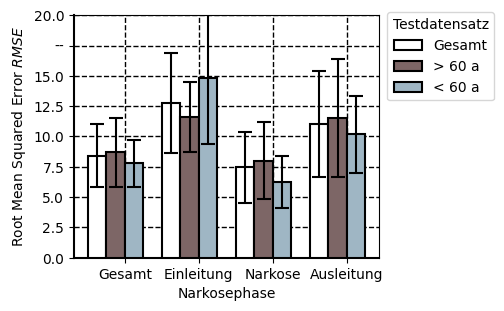

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','> 60 a', '< 60 a']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, old_rep, young_rep]
report_std = [all_rep_std, old_rep_std, young_rep_std]


for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.4, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20.0)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('age_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()

# Testing Gender

## Male

In [14]:
male_rep = phases_report(y_pred[m_index_test], bis.test_dataset[m_index_test], mac.test_dataset[m_index_test])
male_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,67.33,135.78,6.20,7.85,8.21,11.65
Induction,172.40,554.21,9.47,16.64,13.13,23.54
Maintenance,49.65,59.14,5.60,6.12,7.05,7.69
Recovery,134.15,493.81,8.66,16.45,11.58,22.22


In [15]:
male_rep_std = phases_report_std(male_rep,y_pred[m_index_test], bis.test_dataset[m_index_test], mac.test_dataset[m_index_test])
male_rep_std

All      	min: 	 8 	max: 	 20
Induction 	min: 	 2 	max: 	 0
Maintenance 	min: 	 23 	max: 	 20
Recovery 	min: 	 14 	max: 	 13


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,40.06,61.62,2.32,2.66,2.24,2.44
Induction,153.43,287.63,3.38,5.59,4.55,6.63
Maintenance,38.60,41.82,2.51,2.69,2.51,2.65
Recovery,123.01,253.56,4.23,5.89,4.62,5.30


## Female

In [16]:
fem_rep = phases_report(y_pred[f_index_test], bis.test_dataset[f_index_test], mac.test_dataset[f_index_test])
fem_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,77.17,148.44,6.29,8.05,8.78,12.18
Induction,144.06,538.89,8.83,15.98,12.00,23.21
Maintenance,67.56,65.23,5.86,6.23,8.22,8.08
Recovery,100.99,557.64,7.67,17.48,10.05,23.61


In [17]:
fem_rep_std = phases_report_std(fem_rep,y_pred[f_index_test], bis.test_dataset[f_index_test], mac.test_dataset[f_index_test])
fem_rep_std

All      	min: 	 8 	max: 	 13
Induction 	min: 	 8 	max: 	 13
Maintenance 	min: 	 2 	max: 	 13
Recovery 	min: 	 12 	max: 	 7


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,64.57,73.10,2.99,2.52,3.18,2.74
Induction,74.89,371.98,3.29,6.71,3.20,7.84
Maintenance,70.56,51.83,3.28,2.48,3.59,2.52
Recovery,84.21,186.24,3.76,4.13,3.79,4.02


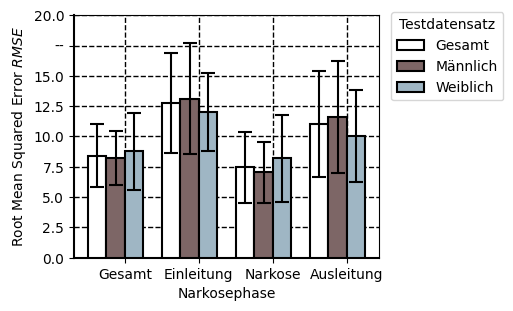

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','Männlich', 'Weiblich']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, male_rep, fem_rep]
report_std = [all_rep_std, male_rep_std, fem_rep_std]

for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.43, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('gender_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()